## importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix

## Importing Dataset

In [2]:
train_dir = 'dataset2/Autistic Children Emotions - Dr. Fatma M. Talaat/Autistic Children Emotions - Dr. Fatma M. Talaat/Train/'
test_dir = 'dataset2/Autistic Children Emotions - Dr. Fatma M. Talaat/Autistic Children Emotions - Dr. Fatma M. Talaat/Test/'
row, col = 224, 224
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = os.path.join(path, expression)
        if os.path.isdir(dir_):
            dict_[expression] = len([f for f in os.listdir(dir_) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    df = pd.DataFrame(dict_, index=[set_])
    return df

train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print("Training set:")
print(train_count)
print("\nTest set:")
print(test_count)

Training set:
       Natural  fear  surprise  sadness  anger  joy
train       48    30        63      200     67  350

Test set:
      Natural  fear  surprise  sadness  anger  joy
test        7     3         6       14      3   42


### PLot of number of images in training set

<AxesSubplot: >

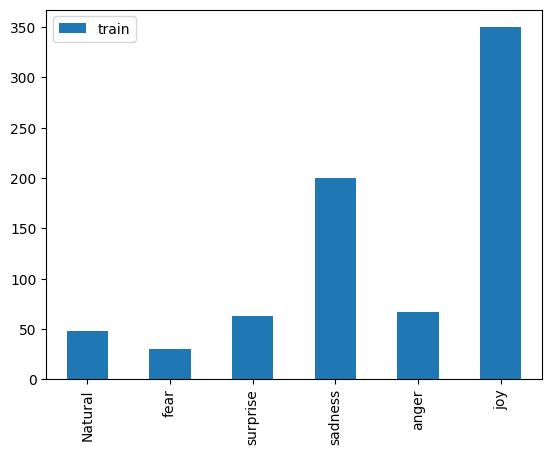

In [3]:
train_count.transpose().plot(kind='bar')

### PLot of number of images in test set

<AxesSubplot: >

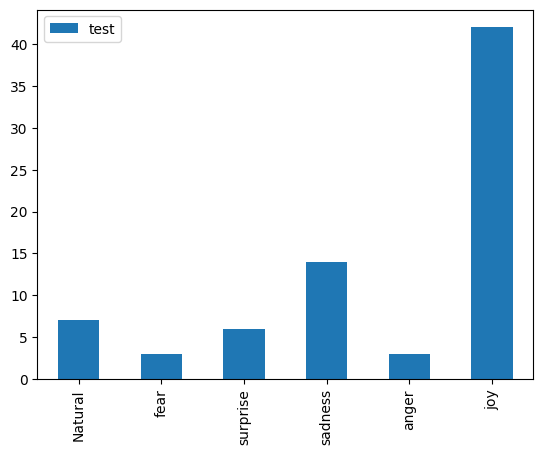

In [4]:
test_count.transpose().plot(kind='bar')

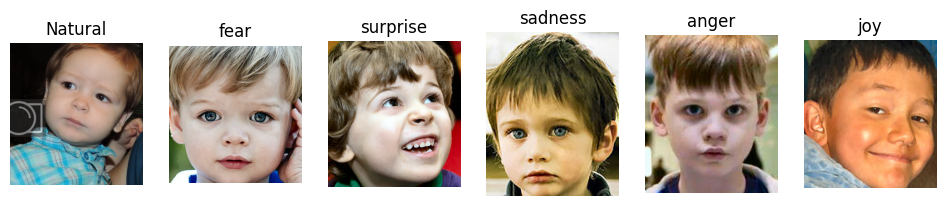

In [5]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    expr_dir = os.path.join(train_dir, expression)
    if os.path.isdir(expr_dir):
        files = [f for f in os.listdir(expr_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if files:
            img_path = os.path.join(expr_dir, files[0])
            img = load_img(img_path)
            plt.subplot(1,7,i)
            plt.imshow(img)
            plt.title(expression)
            plt.axis('off')
            i += 1
plt.show()

## Creating Training and test sets

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(224,224),
                                                shuffle=True,
                                                color_mode='rgb',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(224,224),
                                                shuffle=True,
                                                color_mode='rgb',
                                                class_mode='categorical')

Found 758 images belonging to 6 classes.
Found 75 images belonging to 6 classes.


In [8]:
training_set.class_indices

{'Natural': 0, 'anger': 1, 'fear': 2, 'joy': 3, 'sadness': 4, 'surprise': 5}

## Defining Model

In [ ]:
def get_model(input_size, classes=7):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_size)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(classes, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [ ]:
fernet = get_model((row,col,1), classes)
fernet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 256)       2

### Callbacks Function

In [ ]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

## Training Model

In [ ]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/60
448/448 [==============================] - ETA: 0s - loss: 4.2326 - accuracy: 0.2829
Epoch 00001: val_loss improved from inf to 5.70846, saving model to ferNet.h5
448/448 [==============================] - 84s 188ms/step - loss: 4.2326 - accuracy: 0.2829 - val_loss: 5.7085 - val_accuracy: 0.2401
Epoch 2/60
448/448 [==============================] - ETA: 0s - loss: 3.4217 - accuracy: 0.3434
Epoch 00002: val_loss improved from 5.70846 to 3.08577, saving model to ferNet.h5
448/448 [==============================] - 39s 87ms/step - loss: 3.4217 - accuracy: 0.3434 - val_loss: 3.0858 - val_accuracy: 0.3949
Epoch 3/60
448/448 [==============================] - ETA: 0s - loss: 2.9161 - accuracy: 0.3734
Epoch 00003: val_loss improved from 3.08577 to 2.57435, saving model to ferNet.h5
448/448 [==============================] - 39s 88ms/step - loss: 2.9161 - accuracy: 0.3734 - val_loss: 2.5743 - val_accuracy: 0.4438
Epoch 4/60
448/448 [==============================] - ETA: 0s - loss: 

## Loss and Accuracy plot

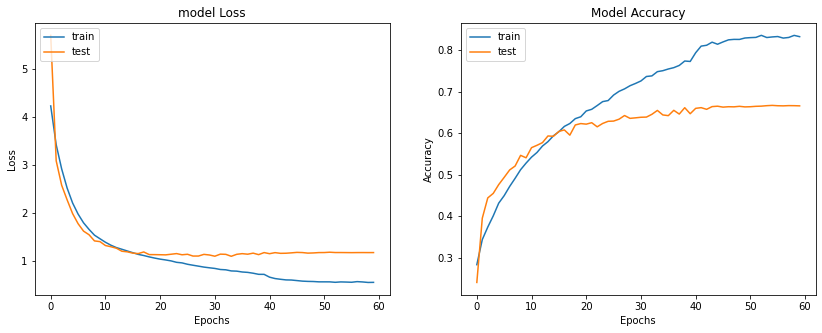

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

high accracy is achieved on training set but accuracy on validation set is stuck at 66% also no overfitting can se seen in the dataset hence is can be concluded that the inefficiency may be due to the unbalanced dataset

### Model evaluation

In [ ]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 4s 38ms/step - loss: 1.1666 - accuracy: 0.6658
final train accuracy = 91.03 , validation accuracy = 66.58


In [ ]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 4s 38ms/step - loss: 1.1666 - accuracy: 0.6658
final train accuracy = 91.03 , validation accuracy = 66.58


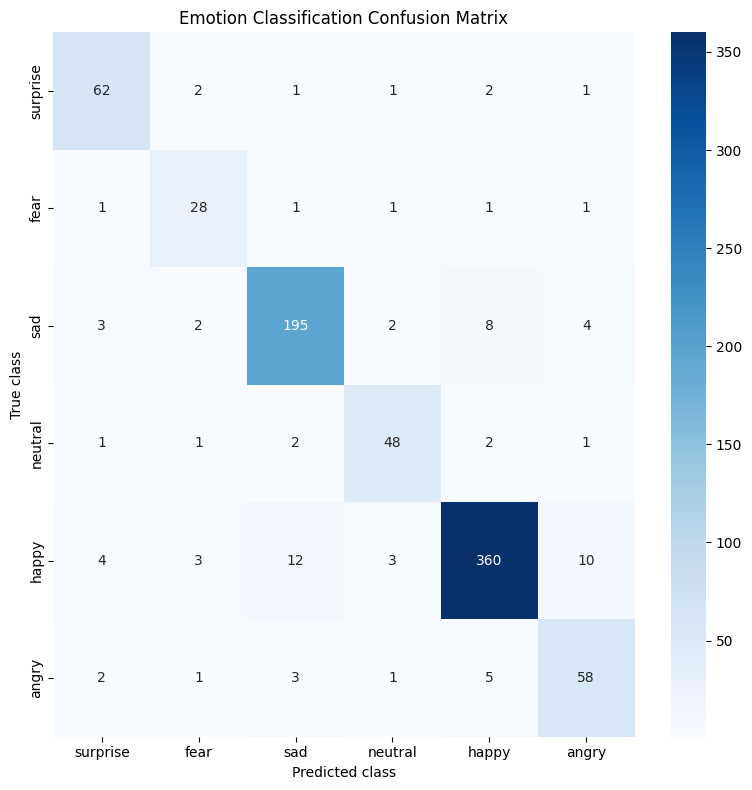

In [ ]:
import seaborn as sns

# Create enhanced heatmap using dynamic confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_train, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names,
            cbar_kws={'label': 'Count'})

plt.title('Confusion Matrix Heatmap - Training Set', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

             precision    recall  f1-score   support
surprise          0.85      0.90      0.87        69
fear              0.76      0.85      0.80        33
sad               0.91      0.91      0.91       214
neutral           0.86      0.87      0.86        55
happy             0.95      0.92      0.94       392
angry             0.77      0.83      0.80        70

accuracy                                0.66       833
macro avg         0.85      0.88      0.86       833
weighted avg      0.90      0.90      0.90       833
